In [1]:
%matplotlib inline

import os
import time
import math
import glob
import shutil
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import h5py

from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image

import torch
from torch.nn import functional as F
from torch.autograd import Variable

##############################
from models import unet
from utils import metrics
from utils import losses
##############################

nr_classes = 5
exp_name = 'unet_df_012_001'
DEVICE = "cuda:0"
WEIGHTS_PATH = 'weights/'

# set device
#device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")
device = "cuda:0"
#device = "cpu"
print(device)

cuda:0


In [2]:
from datetime import datetime

dict_metrics = {"loss":"Loss", "acc_all":"Acc all", "acc_mean":"Acc mean", "jacc":"IoU", "dice":"Dice"}
metric_data = []

def start_log(lr, n_epochs):
    '''
        start log
    '''
    with open("log/{}.txt".format(exp_name), mode='a', encoding='utf-8') as f:
        f.write('#' * 80 + '\n')
        f.write('#' * 29 + '   Start experiment   ' + '#' * 29 + '\n')
        f.write('#' * 80 + '\n')
        f.write('\n')
        f.write('Learning Rate:    {}\n'.format(lr))
        f.write('Number of Epochs: {}\n'.format(n_epochs))
        f.write('\n')
    

def add_log(epoch, metric, time, learing_type):
    '''
        save log
    '''
    with open("log/{}.txt".format(exp_name), mode='a', encoding='utf-8') as f:
        if learing_type == 'train':
            f.write('=' * 80 + '\n')
            f.write('-' * 10 + '\n')
            f.write('Epoch {}\n'.format(epoch))
            f.write('-' * 10 + '\n')
        f.write(learing_type)
        for i in metric:
            f.write(" {}: {:.4f} ".format(dict_metrics[i], metric[i]))
        f.write('\n')
        f.write('-' * 10 + '\n')
        if learing_type == 'val':
            f.write('Time {:.0f}m\n'.format(time))


def start_csv():
    '''
        start csv
    '''
    with open("log/{}.csv".format(exp_name), mode='a', encoding='utf-8') as f:
        for i in dict_metrics:
            f.write("train_{}, ".format(i))
        for i in dict_metrics:
            f.write("val_{}, ".format(i))
        f.write('\n')
        
        
def add_csv(epoch, metric, time, learing_type):
    '''
    '''
    with open("log/{}.csv".format(exp_name), mode='a', encoding='utf-8') as f:
        for i in metric:
            f.write("{:.4f}, ".format(metric[i]))
        if learing_type == 'val':
            f.write('\n')
            
#def add_training_data(metric):
#    metric_cur = list(metric.values()appendnd   metric_data.append(metric_cur)
#    x = np.array(metric_data)
#    np.savetxt('/home/philipp/Downloads/test.csv', x, delimiter=',', fmt='%f', encoding='utf-8')

In [3]:
## Creating the dataset

In [4]:
class ForestDataset(torch.utils.data.Dataset):
    
    '''Characterizes a dataset for PyTorch'''
    
    def __init__(self, path):
        '''Initialization'''
        # open dataset
        self.dset = h5py.File(path, 'r')
        self.ortho = self.dset['ortho']
        self.dsm = self.dset['dsm']
        self.dtm = self.dset['dtm']
        self.slope = self.dset['slope']
        self.ground_truth = self.dset['ground_truth']
        
        # set number of samples
        self.length = self.ground_truth.shape[0]
        #self.labels = labels
        #self.list_IDs = list_IDs
        
        ## TODO:
        # make means and stds load from hdf5
        self.means_tams = np.array([56.12055784563426, 62.130400134006976, 53.03228547781888, 119.50916281232037], dtype='float32')
        self.stds_tams = np.array([30.37628560708646, 30.152693706272483, 23.13718651792004, 49.301477498205074], dtype='float32')
        
        self.means_bisch = np.array([83.31613716286417, 85.44697933106174, 70.84066121306218, 167.94028791166755], dtype='float32')
        self.stds_bisch = np.array([32.83984319374383, 34.07455659071487, 26.668224048951608, 44.375072733566896], dtype='float32')
        
        self.means_dsm = np.array([13.807993078656509]).astype(np.float32)
        self.stds_dsm = np.array([10.449318123686943]).astype(np.float32)
        
        self.means_dtm = np.array([1281.435025217298]).astype(np.float32)
        self.stds_dtm = np.array([314.3216341799771]).astype(np.float32)
        
        self.means_slope = np.array([21.550225010730767]).astype(np.float32)
        self.stds_slope = np.array([11.841692292433436]).astype(np.float32)
        
        #self.transforms = T.Compose([T.ToTensor()])

    def __len__(self):
        '''Denotes the total number of samples'''
        return self.length

    def __getitem__(self, index):
        '''Generates one sample of data'''
        
        # depending on data change mean and std
        if index < 39280:
            means = self.means_tams
            stds = self.stds_tams
        else:
            means = self.means_bisch
            stds = self.stds_bisch
            
        # Load data and get label
        X_ortho = (torch.tensor(self.ortho[index], dtype=torch.float32).permute(2, 0, 1) - \
             means[:, np.newaxis, np.newaxis]) / stds[:, np.newaxis, np.newaxis]
        
        X_dsm = (torch.tensor(self.dsm[index], dtype=torch.float32).permute(2, 0, 1) - self.means_dsm) / self.stds_dsm
        
        X_dtm = (torch.tensor(self.dtm[index], dtype=torch.float32).permute(2, 0, 1) - self.means_dtm) / self.stds_dtm
        
        X_slope = (torch.tensor(self.slope[index], dtype=torch.float32).permute(2, 0, 1) - self.means_slope) / self.stds_slope
        
        #X = np.concatenate([x0, x1, x2, x3], axis=2)
        X = torch.cat((X_ortho, X_dsm, X_dtm, X_slope),0)
        #X = torch.tensor(self.ortho[index], dtype=torch.float32).permute(2, 0, 1) / 255
        
        y = torch.tensor(self.ground_truth[index][:,:,0], dtype=torch.torch.int64)
        
        #X = torch.from_numpy(np.array(self.ortho[index]).transpose(2,0,1)) / 255
        #y = torch.from_numpy(np.array(self.ground_truth[index])[:,:,0], dtype=torch.torch.int64)

        return X, y #torch.from_numpy(y).permute(2, 0, 1)
        
        
    def show_item(self, index):
        '''shows the data'''
        #plt.imshow(np.array(self.ground_truth[index]))
        
        fig = plt.figure(figsize=(20,20))
        
        a = fig.add_subplot(2, 3, 1)
        imgplot = plt.imshow(np.array(self.ortho[index][:,:,:3]))
        a.set_title('RGB')
        plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
        plt.axis('off')
        
        a = fig.add_subplot(2, 3, 2)
        imgplot = plt.imshow(np.array(np.roll(self.ortho[index], 1, axis=2)[:,:,:3]))
        a.set_title('CIR')
        plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
        plt.axis('off')
        
        a = fig.add_subplot(2, 3, 3)
        imgplot = plt.imshow(np.array(self.dsm[index].astype('f')))
        imgplot.set_clim(0.0, 40.0)
        a.set_title('Tree Height')
        plt.colorbar(ticks=[10, 20, 30], orientation='horizontal')
        plt.axis('off')
        
        a = fig.add_subplot(2, 3, 4)
        imgplot = plt.imshow(np.array(self.dtm[index].astype('f')))
        imgplot.set_clim(0.0, 40.0)
        a.set_title('DTM')
        plt.colorbar(ticks=[10, 20, 30], orientation='horizontal')
        plt.axis('off')
        
        a = fig.add_subplot(2, 3, 5)
        imgplot = plt.imshow(np.array(self.slope[index].astype('f')))
        imgplot.set_clim(0.0, 40.0)
        a.set_title('Slope')
        plt.colorbar(ticks=[10, 20, 30], orientation='horizontal')
        plt.axis('off')
        
        a = fig.add_subplot(2, 3, 6)
        imgplot = plt.imshow(np.array(self.ground_truth[index]), cmap="hot")
        imgplot.set_clim(0, 5)
        a.set_title('Ground Truth')
        plt.colorbar(ticks=[0, 1, 2, 3, 4], orientation='horizontal')
        plt.axis('off')
        
        
    def close(self):
        ''' closes the hdf5 file'''
        self.dset.close()

In [5]:
path_dataset = "/home/philipp/Data/dataset_256_df_1.h5"
#path_dataset = "/media/philipp/DATA/dataset/dataset_256_df_0.h5"
data = ForestDataset(path_dataset)
len(data)

75000

In [6]:
X, y = data[1000]
X.shape, y.shape

(torch.Size([7, 256, 256]), torch.Size([256, 256]))

In [7]:
y[0].shape

torch.Size([256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


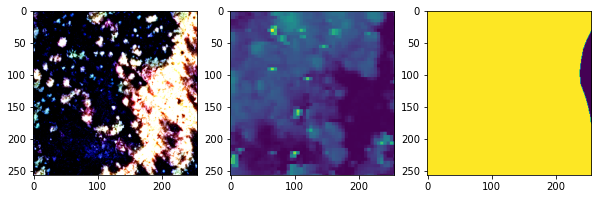

In [8]:
X, y = data[51]
fig, ax = plt.subplots(1,3, figsize=(10,9))
ax[0].imshow(X.permute(1, 2, 0).numpy()[:,:,:3])
ax[1].imshow(X.permute(1, 2, 0).numpy()[:,:,4])
ax[2].imshow(y.numpy())

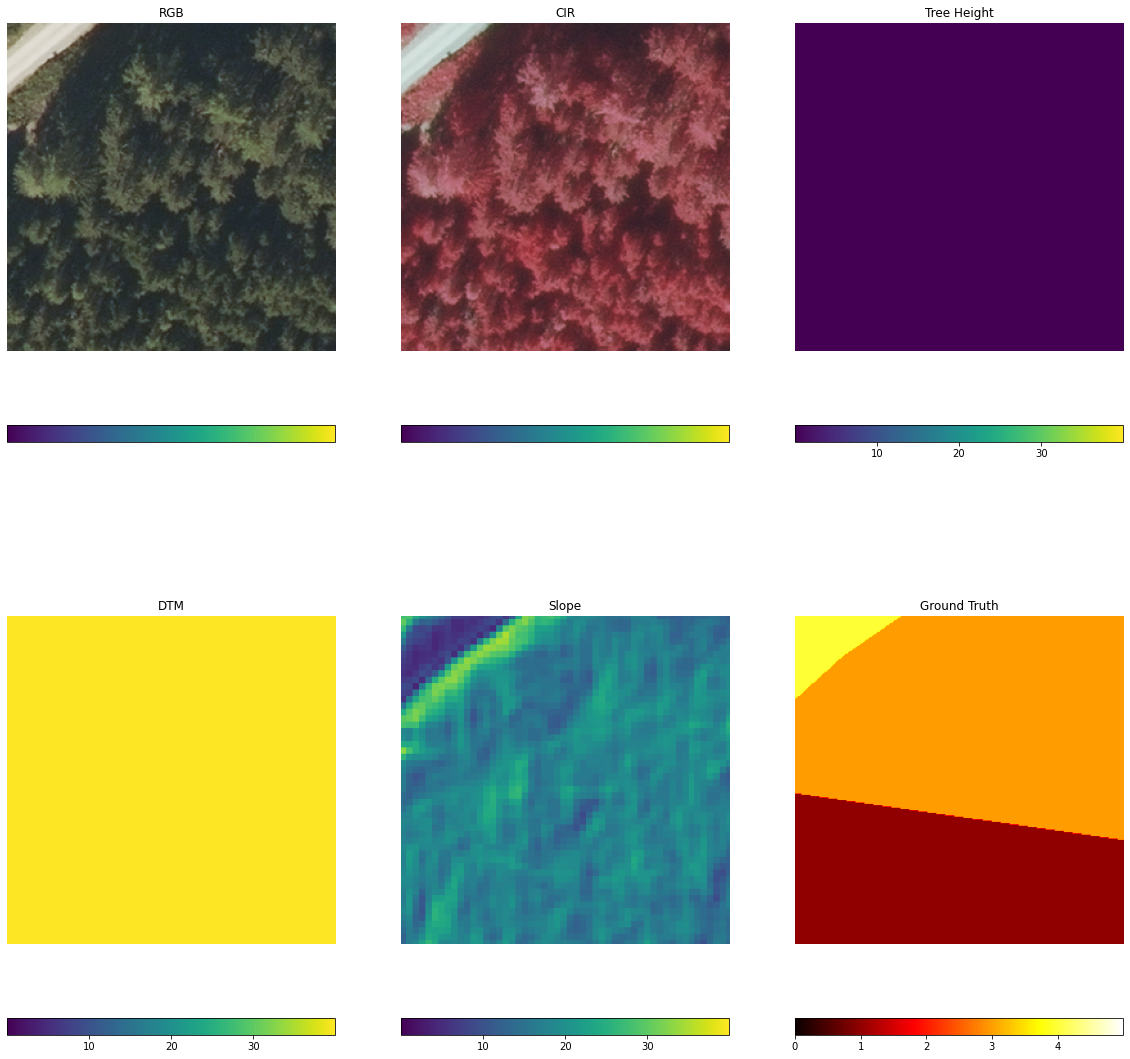

In [9]:
data.show_item(91)

In [10]:
# split data

In [11]:
batch_size = 80
validation_split = .1
test_split = .1
shuffle_dataset = True
random_seed = 399

# Creating data indices for training and validation splits:
dataset_size = 74552
#dataset_size = len(data)
indices = list(range(dataset_size))
split_val = int(np.floor(validation_split * dataset_size))
split_test = int(np.floor(test_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[split_val+split_test:], indices[:split_val], indices[split_val:split_val+split_test]

print(len(train_indices))
print(len(val_indices))
print(len(test_indices))

59642
7455
7455


In [12]:
# Creating PT data samplers and loaders:
train_sampler = sampler.SubsetRandomSampler(train_indices)
valid_sampler = sampler.SubsetRandomSampler(val_indices)
test_sampler = sampler.SubsetRandomSampler(test_indices)

train_dl = torch.utils.data.DataLoader(data, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=4, pin_memory=True)
valid_dl = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                                sampler=valid_sampler, num_workers=4, pin_memory=True)
test_dl = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                                sampler=test_sampler, num_workers=4, pin_memory=True)

In [13]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([80, 7, 256, 256]), torch.Size([80, 256, 256]))

In [14]:
from torch import nn
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 64, 3, 1)
        self.conv2 = self.contract_block(64, 128, 3, 1)
        self.conv3 = self.contract_block(128, 256, 3, 1)
        self.conv4 = self.contract_block(256, 512, 3, 1)
        
        self.upconv4 = self.expand_block(512, 256, 3, 1)
        self.upconv3 = self.expand_block(256*2, 128, 3, 1)
        self.upconv2 = self.expand_block(128*2, 64, 3, 1)
        self.upconv1 = self.expand_block(64*2, out_channels, 3, 1)
        self.softmax = torch.nn.LogSoftmax(dim=1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)

        upconv4 = self.upconv4(conv4)
        
        upconv3 = self.upconv3(torch.cat([upconv4, conv3], 1))
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))
        
        out = self.softmax(upconv1)

        return out

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

In [15]:
RESULTS_PATH = 'results/'
WEIGHTS_PATH = 'weights/'


def save_weights(model, epoch, loss, err):
    weights_fname = 'weights-%d-%.3f-%.3f.pth' % (epoch, loss, err)
    weights_fpath = os.path.join(WEIGHTS_PATH, weights_fname)
    torch.save({
            'startEpoch': epoch,
            'loss':loss,
            'error': err,
            'state_dict': model.state_dict()
        }, weights_fpath)
    shutil.copyfile(weights_fpath, WEIGHTS_PATH+'latest_5d.pt')

def load_weights(model, fpath):
    print("loading weights '{}'".format(fpath))
    weights = torch.load(fpath)
    startEpoch = weights['startEpoch']
    model.load_state_dict(weights['state_dict'])
    print("loaded weights (lastEpoch {}, loss {}, error {})"
          .format(startEpoch-1, weights['loss'], weights['error']))
    return startEpoch

def get_predictions(output_batch):
    bs,c,h,w = output_batch.size()
    tensor = output_batch.data
    values, indices = tensor.cpu().max(1)
    indices = indices.view(bs,h,w)
    return indices

def adjust_learning_rate(lr, decay, optimizer, cur_epoch, n_epochs):
    """Sets the learning rate to the initially
        configured `lr` decayed by `decay` every `n_epochs`"""
    new_lr = lr * (decay ** (cur_epoch // n_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform(m.weight)
        m.bias.data.zero_()

In [16]:
#############
#   train
#############
def train(model, trn_loader, optimizer, criterion, epoch):
    
    model.train()
    step = 0
    metric = {'loss': 0.0, \
              'acc_all':0.0, \
              'acc_mean':0.0, \
              'jacc':0.0, \
              'dice':0.0}

    for idx, data in enumerate(trn_loader):
        x = Variable(data[0].to(device))
        y = Variable(data[1].to(device))
        step += 1
        
        # forward pass
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        
        # backward pass
        loss.backward()
        # update weights
        optimizer.step()

        # calculate predictions
        pred = get_predictions(output)
        
        # calculate metrics for the batch
        overall_acc, avg_per_class_acc, avg_jacc, avg_dice = metrics.eval_metrics(y, pred, num_classes=nr_classes, device=device)
        # update running metrics
        for i, m in zip(metric, [loss, overall_acc, avg_per_class_acc, avg_jacc, avg_dice]):
            metric[i] += m*trn_loader.batch_size
        
        # print metrics to console
        if step % 100 == 0:
            print('Step: {}  Loss: {:.4f}  Acc all: {:.4f}  Acc mean: {:.4f}  IoU: {:.4f}  Dice: {:.4f}'\
                  .format(step, loss, overall_acc, avg_per_class_acc, avg_jacc, avg_dice))
    
    # calculate metrics for the epoch      
    for i in metric:
        metric[i] /= len(train_indices)
                    
    return metric

#############
#   test
#############
def test(model, test_loader, criterion, epoch=1):
    
    model.eval()
    step = 0
    metric = {'loss': 0.0, \
              'acc_all':0.0, \
              'acc_mean':0.0, \
              'jacc':0.0, \
              'dice':0.0}
    
    for data, target in test_loader:
        x = Variable(data.to(device))
        y = Variable(target.to(device))
        step += 1
        
        # forward pass
        with torch.no_grad():
            output = model(x)
            loss = criterion(output, y)
            #test_loss += criterion(output, y).data.item()
            
        # calculate predictions    
        pred = get_predictions(output)
        
        # calculate metrics for the batch
        overall_acc, avg_per_class_acc, avg_jacc, avg_dice = metrics.eval_metrics(y, pred, num_classes=nr_classes, device=device)
        # update running metrics
        for i, m in zip(metric, [loss, overall_acc, avg_per_class_acc, avg_jacc, avg_dice]):
            metric[i] += m*test_loader.batch_size
            
        # print metrics to console
        if step % 100 == 0:
            print('Step: {}  Loss: {:.4f}  Acc all: {:.4f}  Acc mean: {:.4f}  IoU: {:.4f}  Dice: {:.4f}'\
                  .format(step, loss, overall_acc, avg_per_class_acc, avg_jacc, avg_dice))
        
    # calculate metrics for the epoch      
    for i in metric:
        metric[i] /= len(val_indices)
                    
    return metric

In [21]:
LR = 0.03
LR_DECAY = 0.995
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS = 30

In [22]:
model = UNET(in_channels=7, out_channels=nr_classes)
try:
    load_weights(model, WEIGHTS_PATH+'weights-30-0.322-0.781.pth')
    #load_weights(model, WEIGHTS_PATH+'latest_5d.pt')
    print("weights loaded")
except:
    model.apply(weights_init)
    print("no weights found")
    
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = losses.Dice_Loss()
#optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, weight_decay=1e-4)
#criterion = nn.NLLLoss(weight=class_weight.cuda()).cuda()

loading weights 'weights/weights-30-0.322-0.781.pth'
no weights found


<ipython-input-15-40ae8221c1b7>:41: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(m.weight)


In [23]:
'''
model = UNET(in_channels=5, out_channels=nr_classes)
model.load_state_dict(torch.load(WEIGHTS_PATH+'latest.pt'))
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = losses.Dice_Loss()
'''

"\nmodel = UNET(in_channels=5, out_channels=nr_classes)\nmodel.load_state_dict(torch.load(WEIGHTS_PATH+'latest.pt'))\nmodel.to(device)\noptimizer = torch.optim.Adam(model.parameters(), lr=LR)\ncriterion = losses.Dice_Loss()\n"

In [ ]:
start_log(LR, N_EPOCHS)
start_csv()

for epoch in range(1, N_EPOCHS+1):
    since = time.time()
    
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch, N_EPOCHS))
    print('-' * 10)

    ### Train ###
    metric = train(model, train_dl, optimizer, criterion, epoch)
    # print metrics to console
    print('Epoch {}/{}'.format(epoch, N_EPOCHS))
    print('-' * 10)
    print('Train Loss: {:.4f}  Acc all: {:.4f}  Acc mean: {:.4f}  IoU: {:.4f}  Dice: {:.4f}'\
          .format(metric['loss'], metric['acc_all'], metric['acc_mean'], metric['jacc'], metric['dice']))
    print('-' * 10)
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    add_log(epoch, metric, time_elapsed // 60, 'train')
    add_csv(epoch, metric, time_elapsed // 60, 'train')
    
    ### Test ###
    metric = test(model, valid_dl, criterion, epoch) 
    print('-' * 10)
    print('Val Loss: {:.4f}  Acc all: {:.4f}  Acc mean: {:.4f}  IoU: {:.4f}  Dice: {:.4f}'\
          .format(metric['loss'], metric['acc_all'], metric['acc_mean'], metric['jacc'], metric['dice']))
    print('-' * 10)
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))
    add_log(epoch, metric, time_elapsed // 60, 'val')
    add_csv(epoch, metric, time_elapsed // 60, 'val')
    
    ### Checkpoint ###    
    save_weights(model, epoch, metric['loss'], metric['acc_all'])

    ### Adjust Lr ###
    adjust_learning_rate(LR, LR_DECAY, optimizer, epoch, DECAY_EVERY_N_EPOCHS)

----------
Epoch 1/30
----------
Step: 100  Loss: 0.4400  Acc all: 0.7000  Acc mean: 0.5853  IoU: 0.4649  Dice: 0.5691
Step: 200  Loss: 0.4617  Acc all: 0.6220  Acc mean: 0.5197  IoU: 0.4387  Dice: 0.5412
Step: 300  Loss: 0.4246  Acc all: 0.6563  Acc mean: 0.5868  IoU: 0.4446  Dice: 0.5766
Step: 400  Loss: 0.3936  Acc all: 0.6840  Acc mean: 0.6073  IoU: 0.4942  Dice: 0.6076
Step: 500  Loss: 0.4032  Acc all: 0.7142  Acc mean: 0.5773  IoU: 0.4989  Dice: 0.5977
Step: 600  Loss: 0.3658  Acc all: 0.7074  Acc mean: 0.6288  IoU: 0.5295  Dice: 0.6349
Step: 700  Loss: 0.3702  Acc all: 0.6984  Acc mean: 0.6245  IoU: 0.5203  Dice: 0.6304
Epoch 1/30
----------
Train Loss: 0.4405  Acc all: 0.6794  Acc mean: 0.5627  IoU: 0.4583  Dice: 0.5628
----------
Train Time 8m 41s
----------
Val Loss: 0.4007  Acc all: 0.6761  Acc mean: 0.6032  IoU: 0.4974  Dice: 0.6086
----------
Total Time 9m 13s

----------
Epoch 2/30
----------
Step: 100  Loss: 0.4327  Acc all: 0.6496  Acc mean: 0.5543  IoU: 0.4582  Dice: 0

In [ ]:
# plot traing loss
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

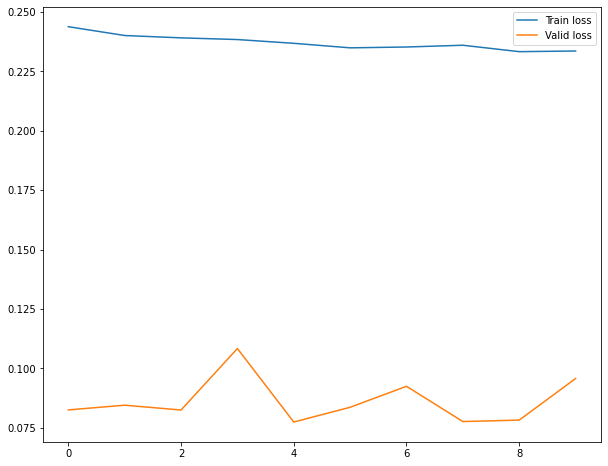

In [18]:
# plot traing loss
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

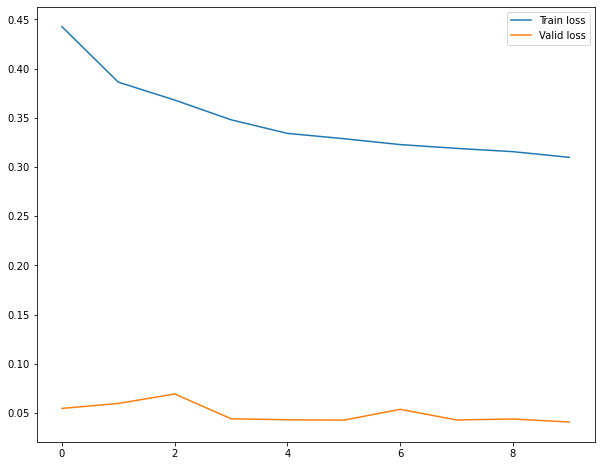

In [18]:
# plot traing loss
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

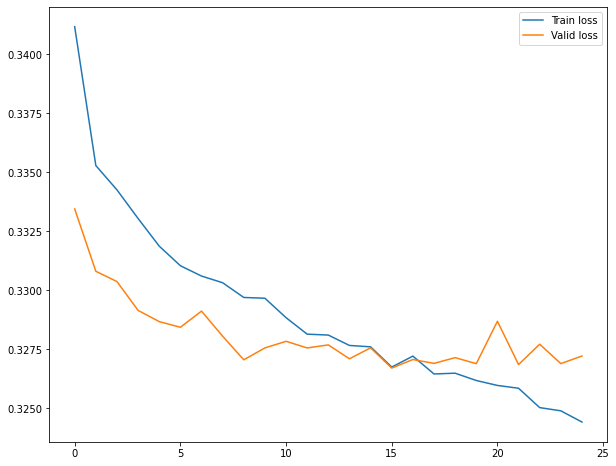

In [37]:
# plot traing loss
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

In [18]:
# predict

In [27]:
test(model, test_dl, criterion, epoch=1)

Step: 100  Loss: 0.4370  Acc all: 0.6968  Acc mean: 0.5662  IoU: 0.4639  Dice: 0.5631
Step: 200  Loss: 0.3548  Acc all: 0.6757  Acc mean: 0.6438  IoU: 0.5423  Dice: 0.6452


{'loss': tensor(0.3553, device='cuda:0'),
 'acc_all': tensor(0.7723),
 'acc_mean': tensor(0.6529),
 'jacc': tensor(0.5544),
 'dice': tensor(0.6467)}

In [46]:
import numpy as np
import matplotlib.pyplot as plt

Void = [0,0,0] # gray
Grass = [245,230,15] # yellow
Decidous = [225,27,27] # red
Conifers = [60,200,60] # green
No_Forest = [30,90,215] # blue

DSET_MEAN = [0.41189489566336, 0.4251328133025, 0.4326707089857]
DSET_STD = [0.27413549931506, 0.28506257482912, 0.28284674400252]

label_colours = np.array([Void, Grass, Decidous, Conifers, No_Forest])


def view_annotated(tensor, plot=True):
    temp = tensor.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,5):
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb)
        plt.show()
    else:
        return rgb

def decode_image(tensor):
    inp = tensor.numpy().transpose((1, 2, 0))
    #mean = np.array(DSET_MEAN)
    #std = np.array(DSET_STD)
    #inp = data.stds_wien * inp + data.means_wien
    return inp

def view_image(tensor):
    inp = decode_image(tensor)
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.show()

In [47]:
def view_sample_predictions(model, loader, n):
    inputs, targets = next(iter(loader))
    data = Variable(inputs.cuda())
    label = Variable(targets.cuda())
    with torch.no_grad():
        output = model(data)
    pred = get_predictions(output)
    batch_size = inputs.size(0)
    for i in range(min(n, batch_size)):
        #img_utils.view_image(inputs[i])
        #img_utils.view_annotated(targets[i])
        #img_utils.view_annotated(pred[i])
        view_image(inputs[i,:3])
        view_annotated(targets[i])
        view_annotated(pred[i])

In [48]:
data.means_mariazell

array([ 52.578648,  63.173195,  59.55805 , 101.360756], dtype=float32)

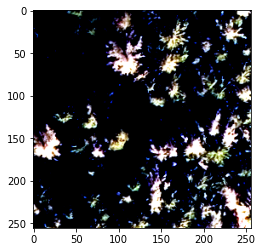

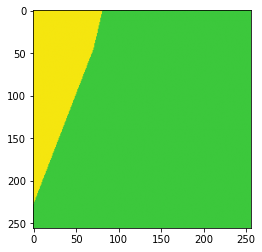

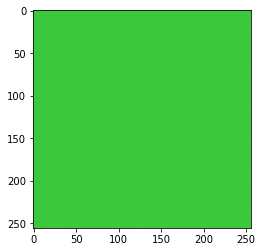

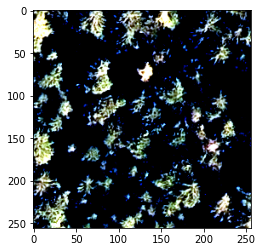

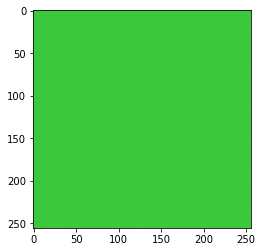

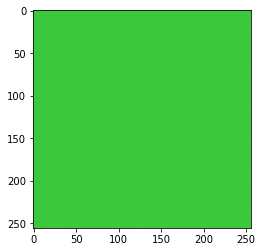

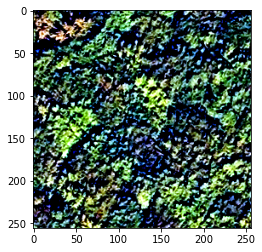

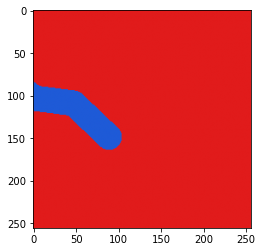

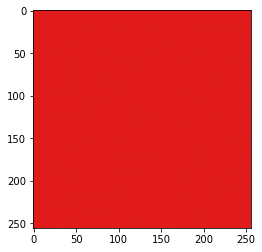

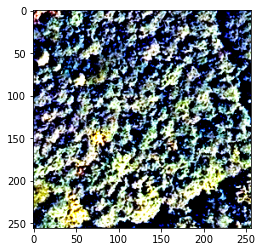

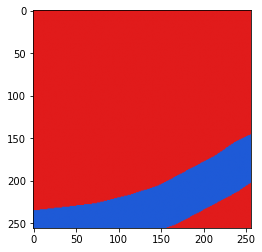

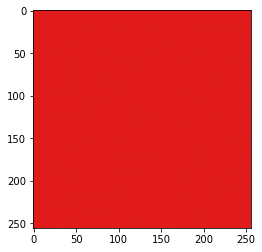

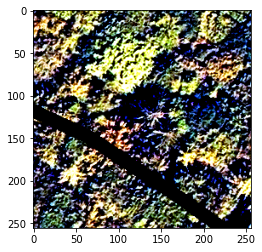

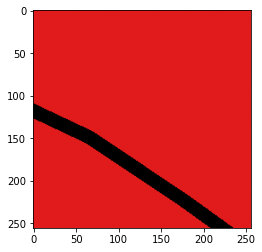

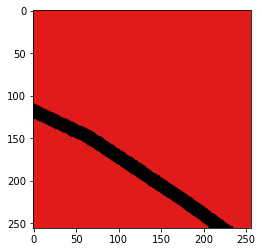

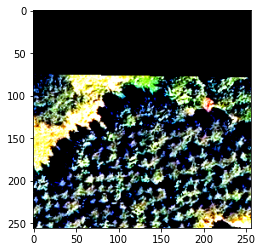

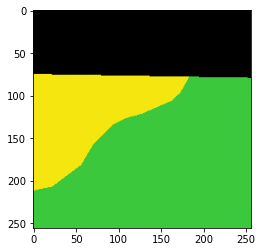

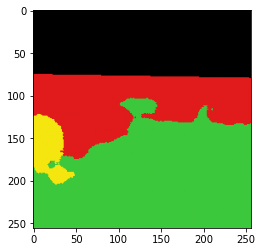

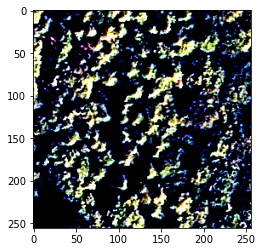

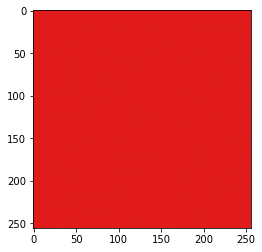

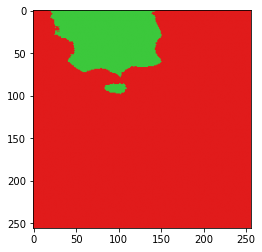

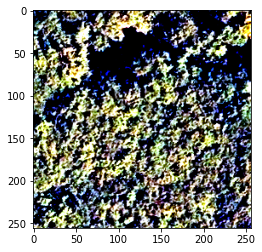

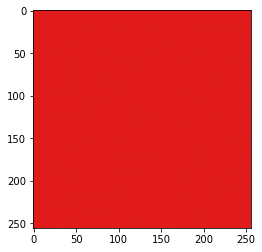

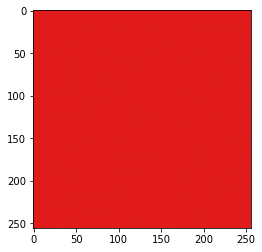

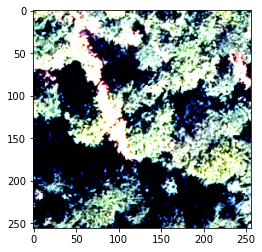

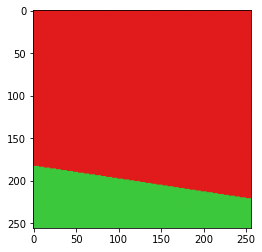

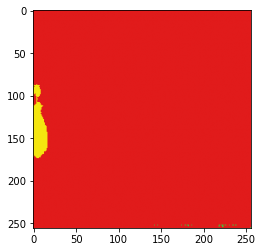

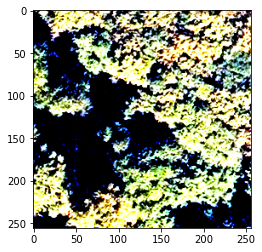

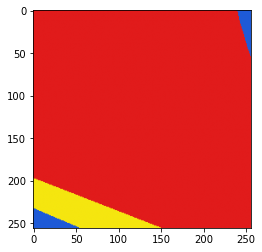

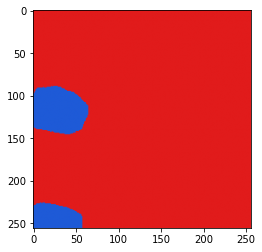

In [49]:
view_sample_predictions(model, valid_dl, n=10)

In [ ]:
view_sample_predictions(model, test_dl, n=10)

In [28]:
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

In [29]:
xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = unet(xb.to(device))

predb.shape

TypeError: 'module' object is not callable

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NameError: name 'predb' is not defined

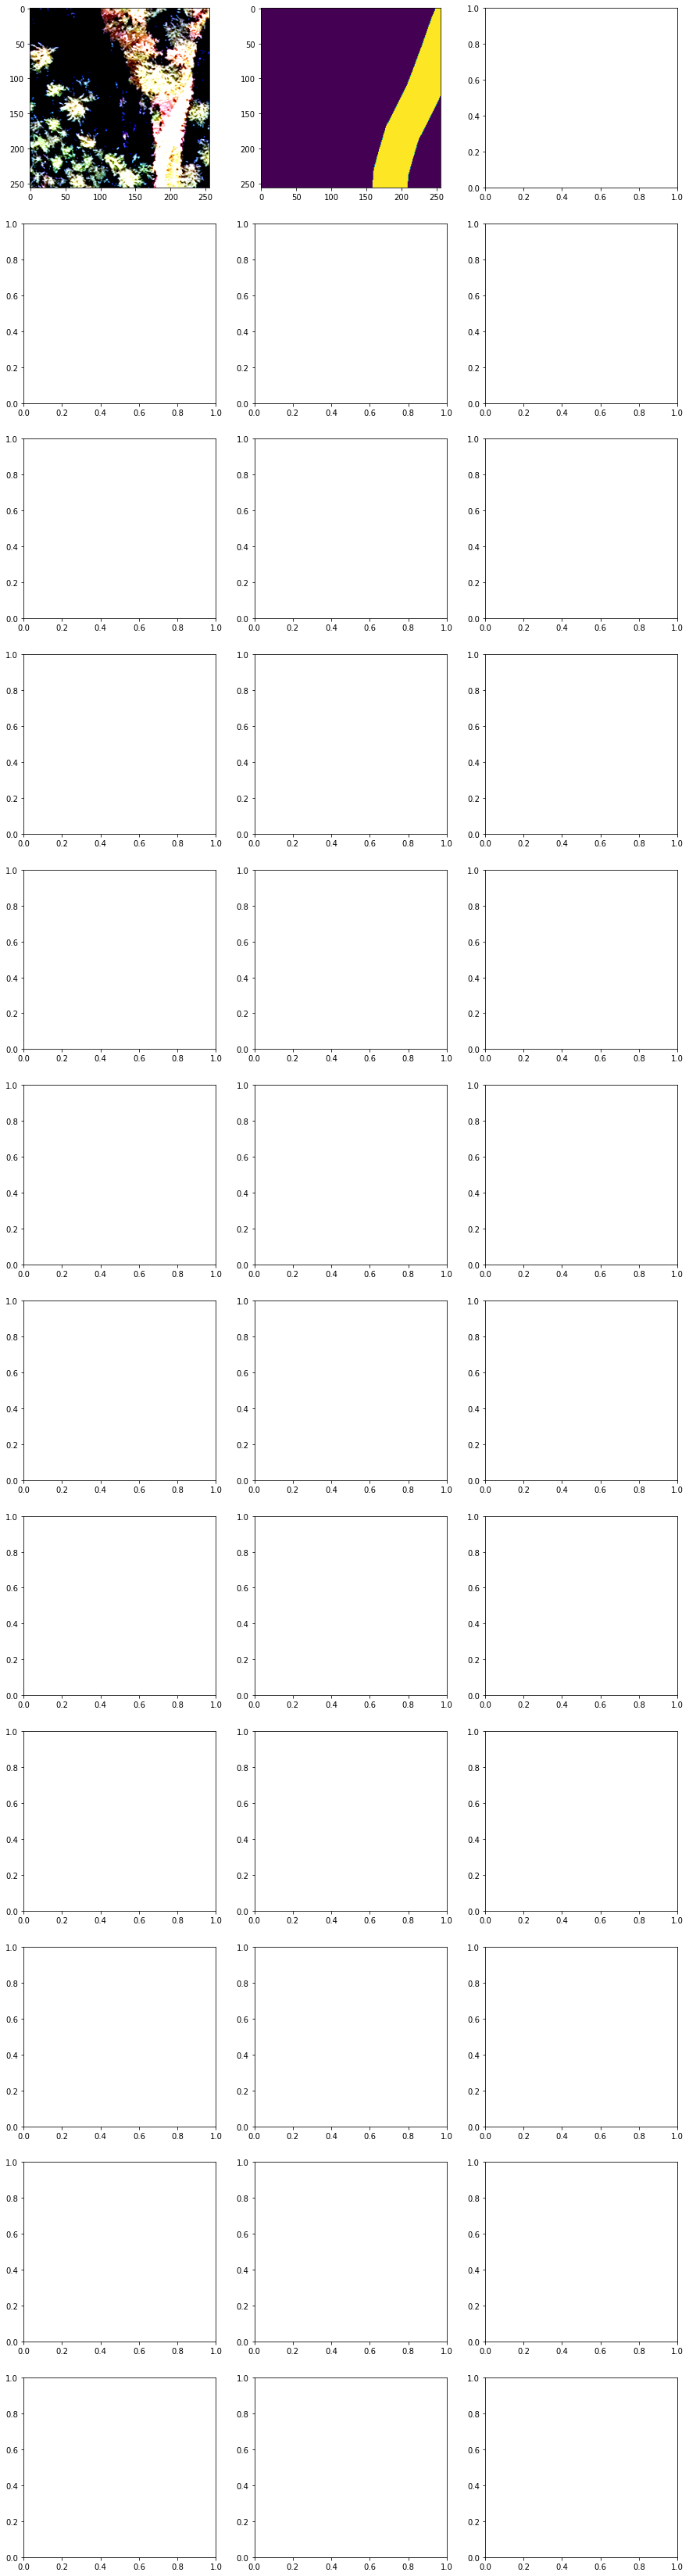

In [30]:
bs = 12
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

In [24]:
# save using pickle
#torch.save(unet,Path('model/unet_typ.pkl'))

# save 
torch.save(unet.state_dict(), SAVE_PATH)